In [1]:
import os
HOME = os.getcwd()
HOME = HOME[0:HOME.find("notebooks")]
DATA_FOLDER = HOME + "data/"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Setting plot styles
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

# Water Potability Detection: Exploratory Data Analysis

This notebook explores a dataset about water quality measurements and their relation to potability. We'll analyze various features to understand what makes water potable or non-potable.

## 1. Load and Inspect the Data

First, let's load the dataset and examine its structure, including basic information about the dataset such as shape, data types, and summary statistics.

In [3]:
# Load the dataset
data = pd.read_csv(DATA_FOLDER+"data.csv")

# Display first few rows
print("First 5 rows of the dataset:")
display(data.head())

First 5 rows of the dataset:


ph  Hardness   Solids  Chloramines  Sulfate  Conductivity  \
0  7.09    190.34  2229.84         0.45   237.96        914.15   
1  8.41     66.79  8212.70         1.61   220.74        875.74   
2  8.18    141.28  5775.82         1.45   133.17        957.36   
3  6.84    123.10  3541.35         1.91   198.81        801.36   
4  7.69    126.76  1104.77         1.35   281.28        556.41   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0            6.52            14.58       0.26           1  
1            4.29            49.15       1.08           0  
2            8.78             8.75       1.32           1  
3            6.02            39.59       1.41           1  
4            7.81             0.69       1.79           1

In [4]:
# Get basic information about the dataset
print("Dataset Shape:", data.shape)
print("\nData Types:")
display(data.dtypes)

print("\nDataset Summary:")
display(data.describe())

# Check for missing values
print("\nMissing Values Count:")
display(data.isnull().sum())
print(f"\nTotal missing values: {data.isnull().sum().sum()}")

# Check for duplicate rows
duplicates = data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

Dataset Shape: (5000, 10)

Data Types:


ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object


Dataset Summary:


ph     Hardness       Solids  Chloramines      Sulfate  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      7.493620   125.216270  5226.987024     0.993504   223.504058   
std       0.575652    43.047514  2753.888598     0.581315    72.264755   
min       6.500000    50.030000   500.520000     0.000000   100.060000   
25%       7.010000    88.535000  2823.722500     0.490000   160.825000   
50%       7.490000   124.515000  5206.110000     0.980000   223.850000   
75%       8.000000   162.382500  7595.775000     1.500000   284.690000   
max       8.500000   200.000000  9998.720000     2.000000   349.980000   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   5000.000000     5000.000000      5000.000000  5000.000000  5000.000000  
mean     603.974318        5.505166        25.010710     1.044790     0.789600  
std      232.402392        2.623663        14.497078     0.538203     0.407634  
min      200.300000        1.000000         0.000000     0.100000     0.000000  
25%      404.567500        3.210000        12.140000     0.580000     1.000000  
50%      606.270000        5.510000        25.190000     1.030000     1.000000  
75%      807.665000        7.780000        37.472500     1.510000     1.000000  
max      999.920000       10.000000        49.990000     2.000000     1.000000


Missing Values Count:


ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


Total missing values: 0

Number of duplicate rows: 0


## 2. Data Cleaning and Preprocessing

Now let's handle any missing values, check for duplicates, and perform necessary data transformations to create a clean dataset for analysis.


Missing values after cleaning:


ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

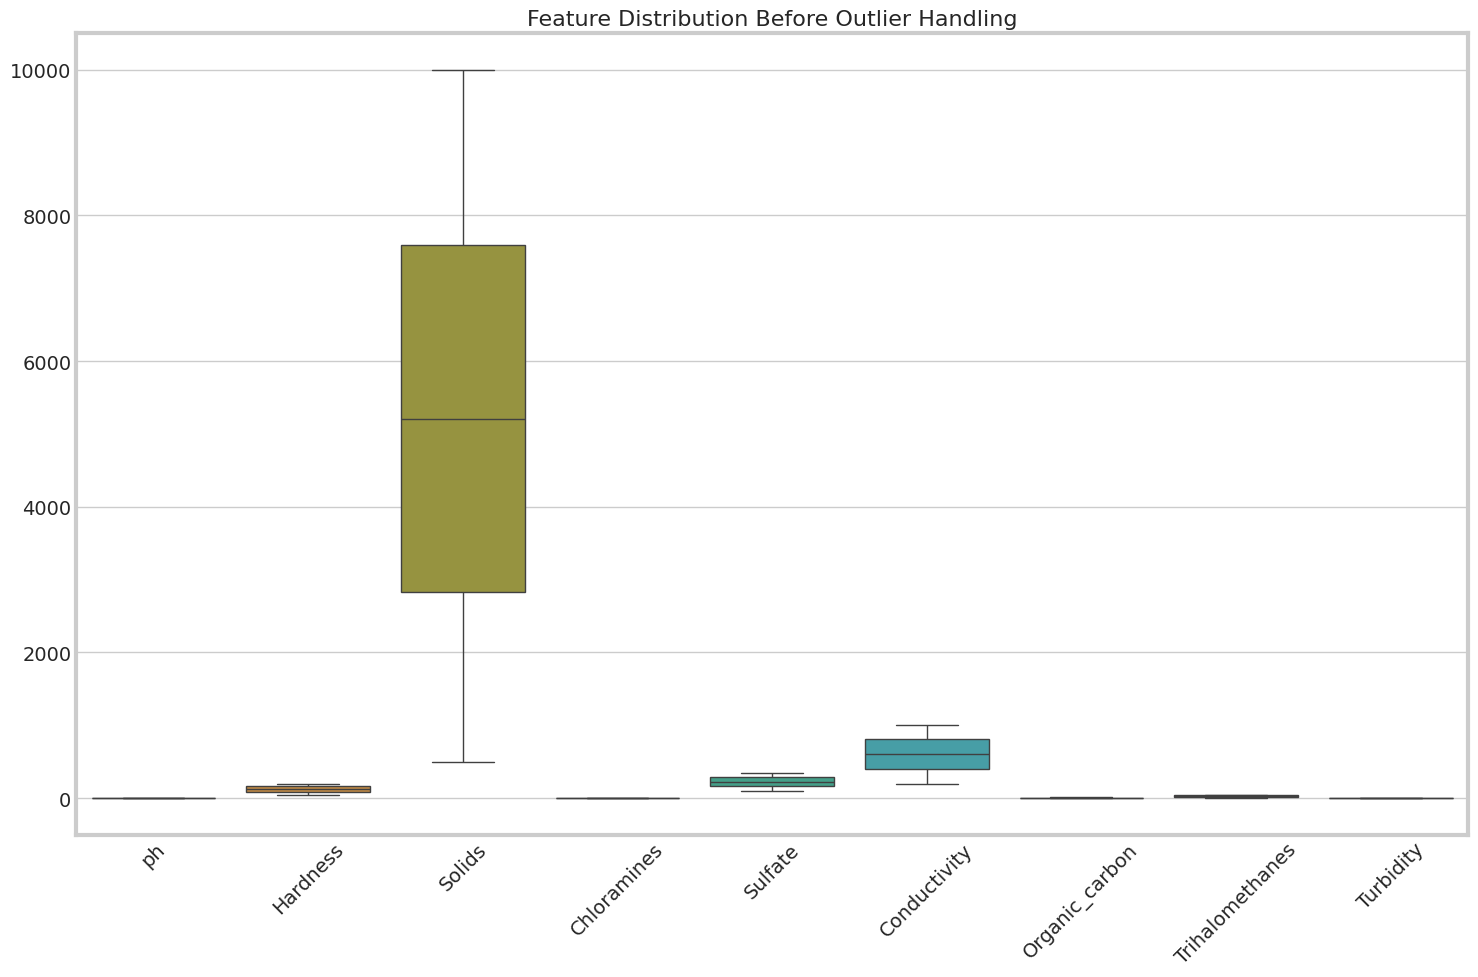

In [5]:
# Create a copy of the original data for cleaning
clean_data = data.copy()

# Handle missing values - fill with median for each column
for column in clean_data.columns:
    if clean_data[column].isnull().sum() > 0:
        median_value = clean_data[column].median()
        print(f"Filling missing values in {column} with median: {median_value:.4f}")
        clean_data[column] = clean_data[column].fillna(median_value)

# Verify no missing values remain
print("\nMissing values after cleaning:")
display(clean_data.isnull().sum())

# Create a boxplot to visualize the distribution of each feature
plt.figure(figsize=(15, 10))
sns.boxplot(data=clean_data.iloc[:, :-1])
plt.title('Feature Distribution Before Outlier Handling', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Exploratory Data Analysis

Let's perform univariate analysis of each feature to understand their distributions and characteristics. We'll also analyze the distribution of our target variable (Potability).

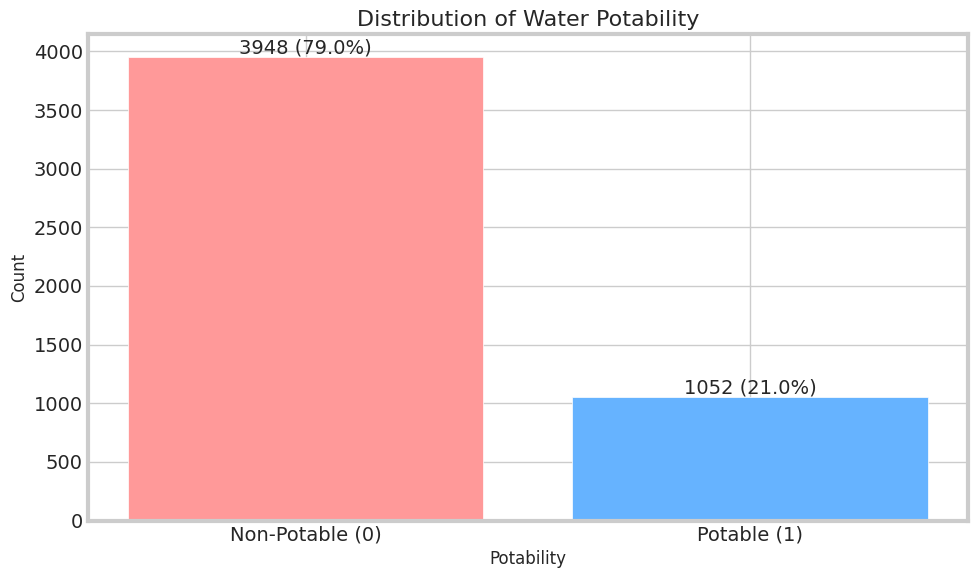

Potable water samples: 3948 (78.96%)
Non-potable water samples: 1052 (21.04%)


In [6]:
# Plot distribution of target variable
plt.figure(figsize=(10, 6))
potability_counts = clean_data['Potability'].value_counts()
plt.bar(['Non-Potable (0)', 'Potable (1)'], potability_counts.values, color=['#ff9999', '#66b3ff'])
plt.title('Distribution of Water Potability', fontsize=16)
plt.xlabel('Potability', fontsize=12)
plt.ylabel('Count', fontsize=12)
for i, count in enumerate(potability_counts.values):
    plt.text(i, count + 30, f'{count} ({count/len(clean_data)*100:.1f}%)', ha='center')
plt.tight_layout()
plt.show()

print(f"Potable water samples: {potability_counts[1]} ({potability_counts[1]/len(clean_data)*100:.2f}%)")
print(f"Non-potable water samples: {potability_counts[0]} ({potability_counts[0]/len(clean_data)*100:.2f}%)")

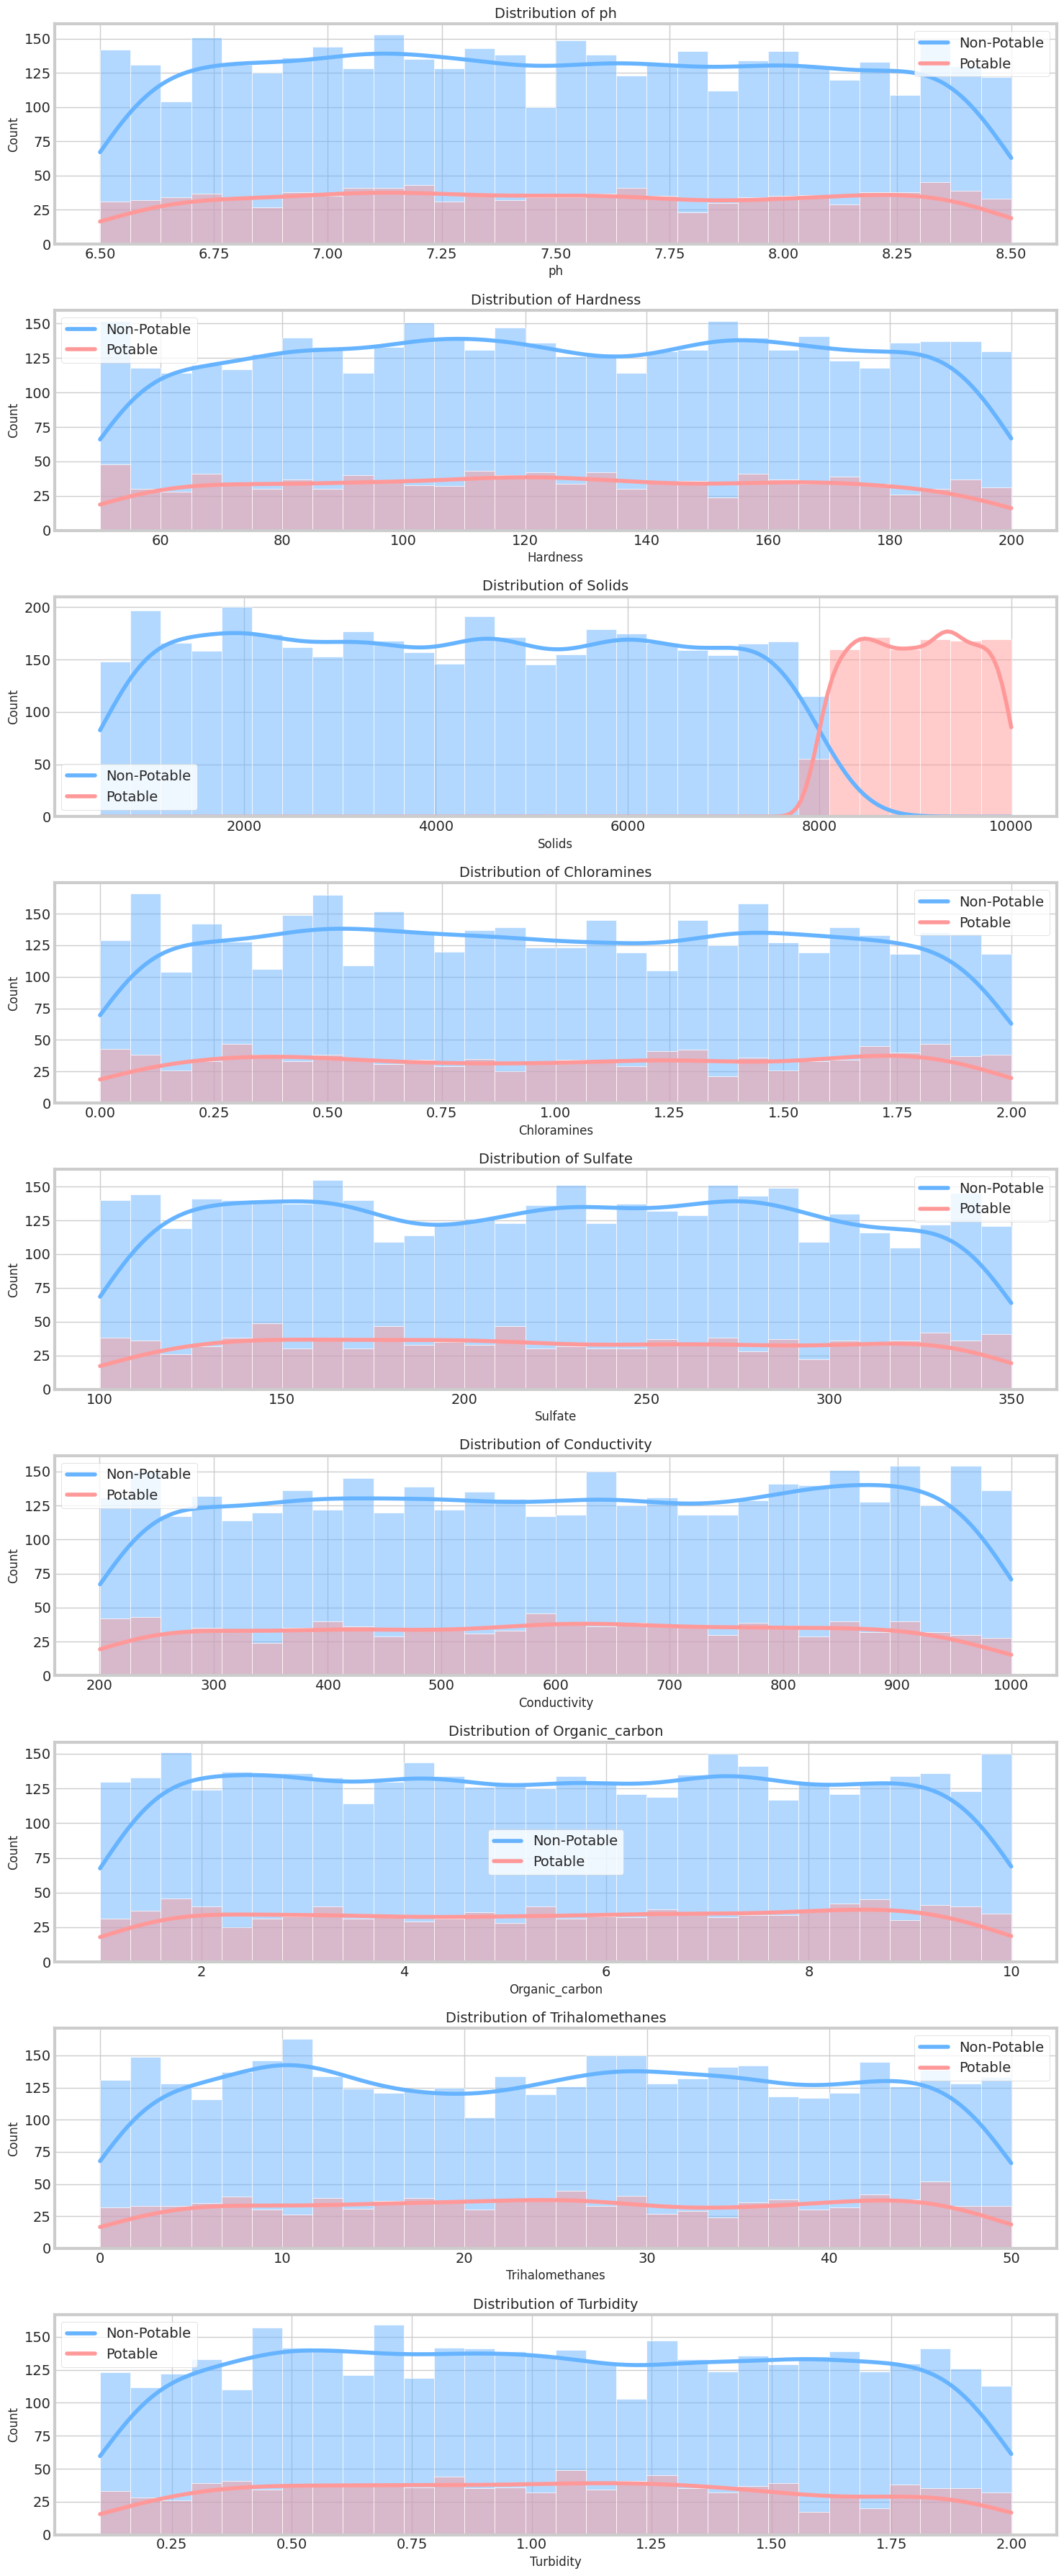

In [7]:
# Plot histograms for each feature
feature_columns = clean_data.columns[:-1]  # All columns except Potability
n_features = len(feature_columns)

fig, axes = plt.subplots(n_features, 1, figsize=(15, 4*n_features))
for i, column in enumerate(feature_columns):
    sns.histplot(clean_data, x=column, hue='Potability', bins=30, kde=True, ax=axes[i], palette=['#ff9999', '#66b3ff'])
    axes[i].set_title(f'Distribution of {column}', fontsize=14)
    axes[i].set_xlabel(column, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].legend(['Non-Potable', 'Potable'])

plt.tight_layout()
plt.show()

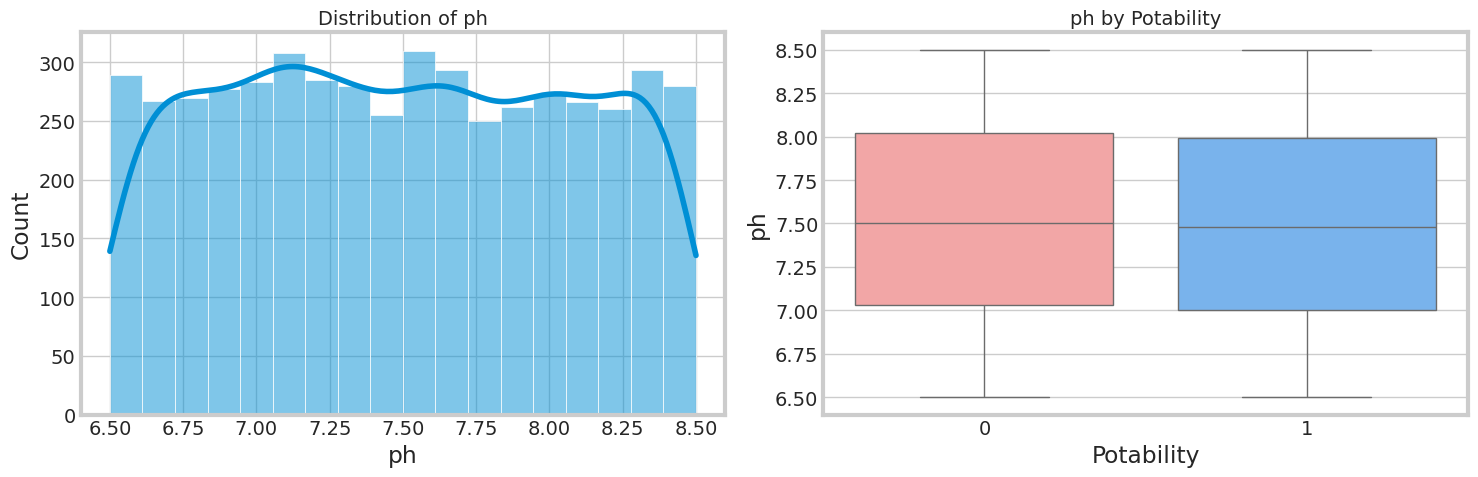

Statistics for ph:
count    5000.000000
mean        7.493620
std         0.575652
min         6.500000
25%         7.010000
50%         7.490000
75%         8.000000
max         8.500000
Name: ph, dtype: float64

Mean for Potable: 7.4894
Mean for Non-Potable: 7.5094
T-test p-value: 0.3177
No significant difference in ph between potable and non-potable water.
--------------------------------------------------------------------------------


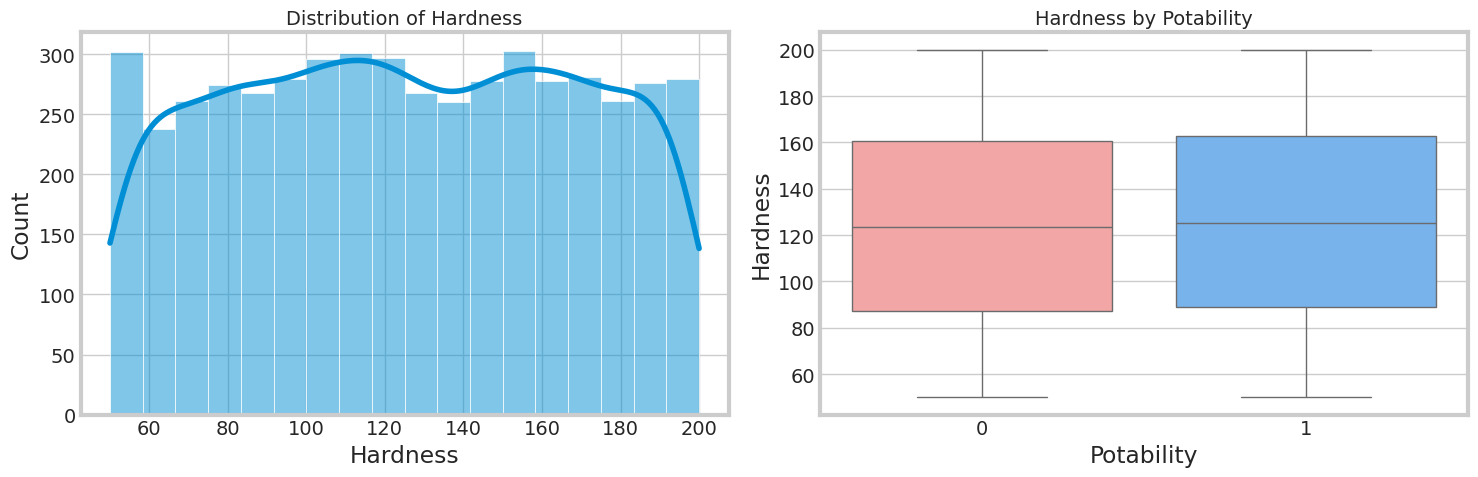

Statistics for Hardness:
count    5000.000000
mean      125.216270
std        43.047514
min        50.030000
25%        88.535000
50%       124.515000
75%       162.382500
max       200.000000
Name: Hardness, dtype: float64

Mean for Potable: 125.5939
Mean for Non-Potable: 123.7993
T-test p-value: 0.2284
No significant difference in Hardness between potable and non-potable water.
--------------------------------------------------------------------------------


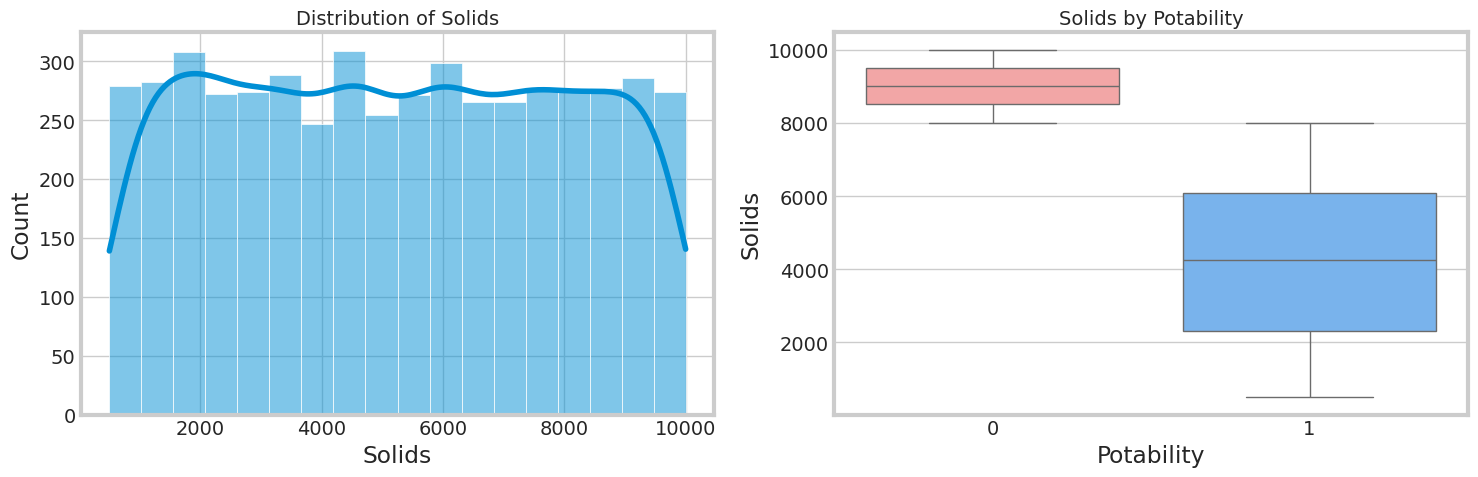

Statistics for Solids:
count    5000.000000
mean     5226.987024
std      2753.888598
min       500.520000
25%      2823.722500
50%      5206.110000
75%      7595.775000
max      9998.720000
Name: Solids, dtype: float64

Mean for Potable: 4220.3004
Mean for Non-Potable: 9004.9328
T-test p-value: 0.0000
The difference in Solids between potable and non-potable water is statistically significant.
--------------------------------------------------------------------------------


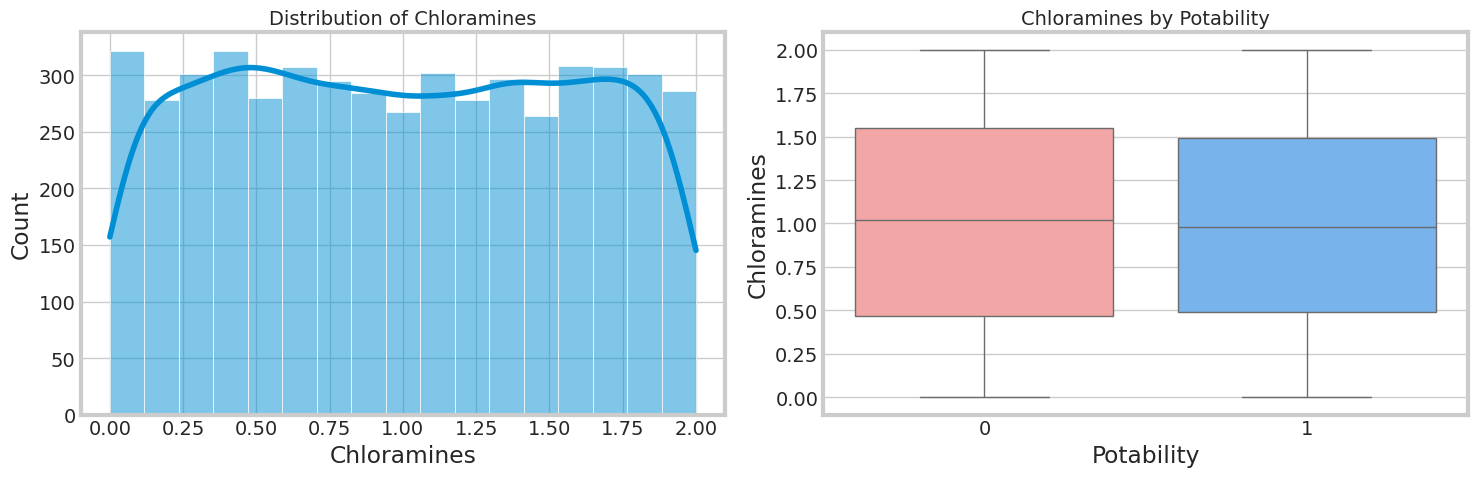

Statistics for Chloramines:
count    5000.000000
mean        0.993504
std         0.581315
min         0.000000
25%         0.490000
50%         0.980000
75%         1.500000
max         2.000000
Name: Chloramines, dtype: float64

Mean for Potable: 0.9897
Mean for Non-Potable: 1.0079
T-test p-value: 0.3741
No significant difference in Chloramines between potable and non-potable water.
--------------------------------------------------------------------------------


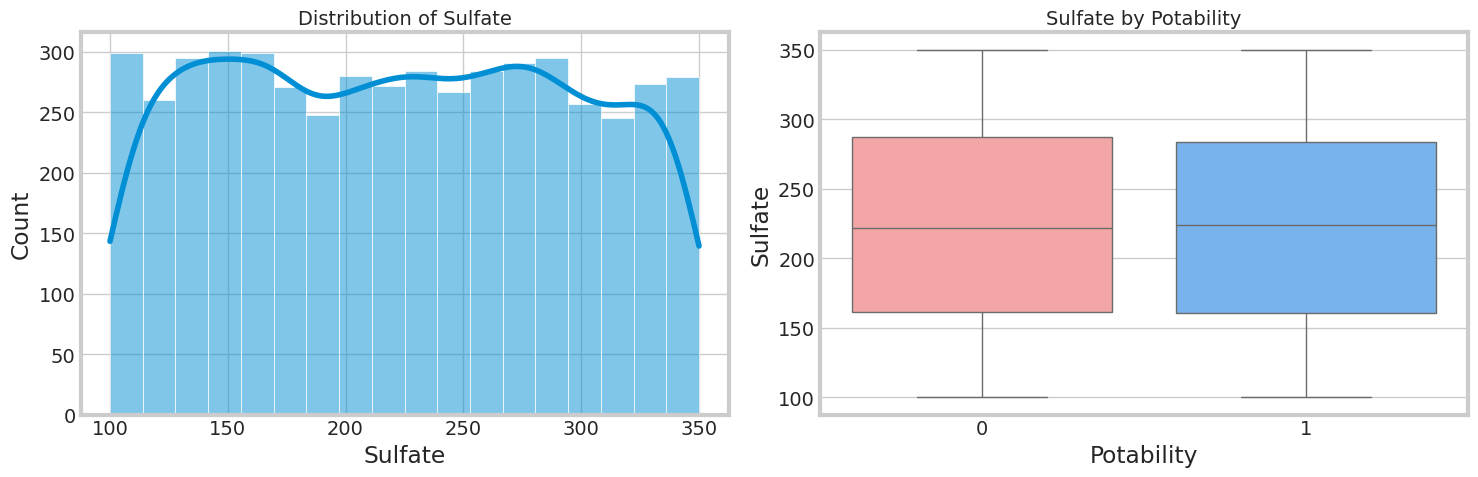

Statistics for Sulfate:
count    5000.000000
mean      223.504058
std        72.264755
min       100.060000
25%       160.825000
50%       223.850000
75%       284.690000
max       349.980000
Name: Sulfate, dtype: float64

Mean for Potable: 223.1910
Mean for Non-Potable: 224.6789
T-test p-value: 0.5560
No significant difference in Sulfate between potable and non-potable water.
--------------------------------------------------------------------------------


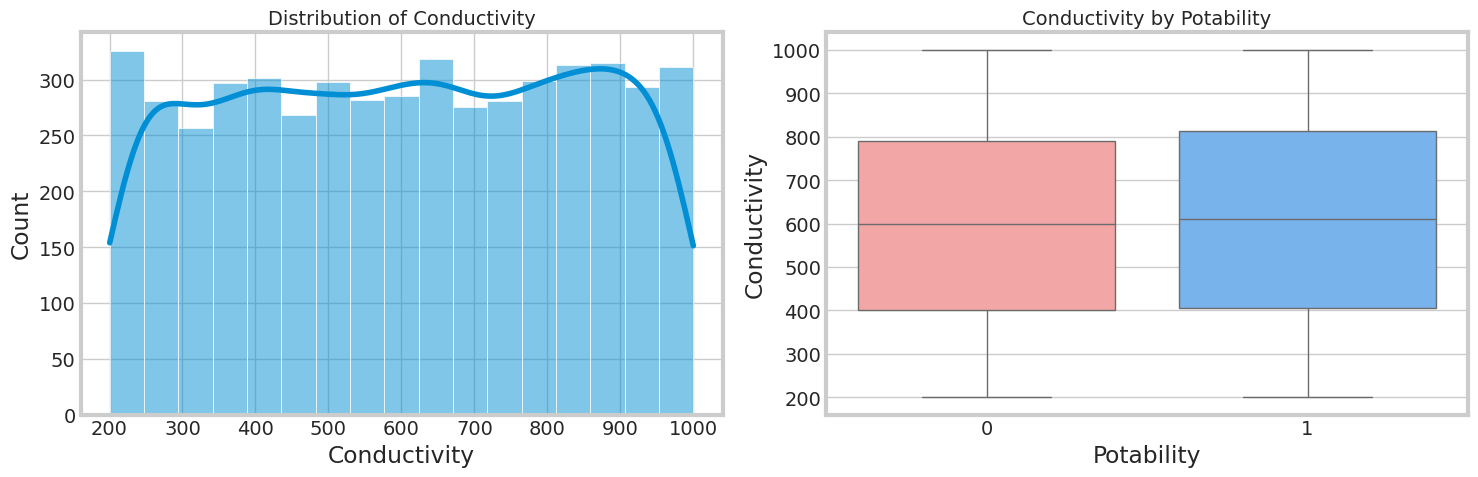

Statistics for Conductivity:
count    5000.000000
mean      603.974318
std       232.402392
min       200.300000
25%       404.567500
50%       606.270000
75%       807.665000
max       999.920000
Name: Conductivity, dtype: float64

Mean for Potable: 606.2697
Mean for Non-Potable: 595.3601
T-test p-value: 0.1716
No significant difference in Conductivity between potable and non-potable water.
--------------------------------------------------------------------------------


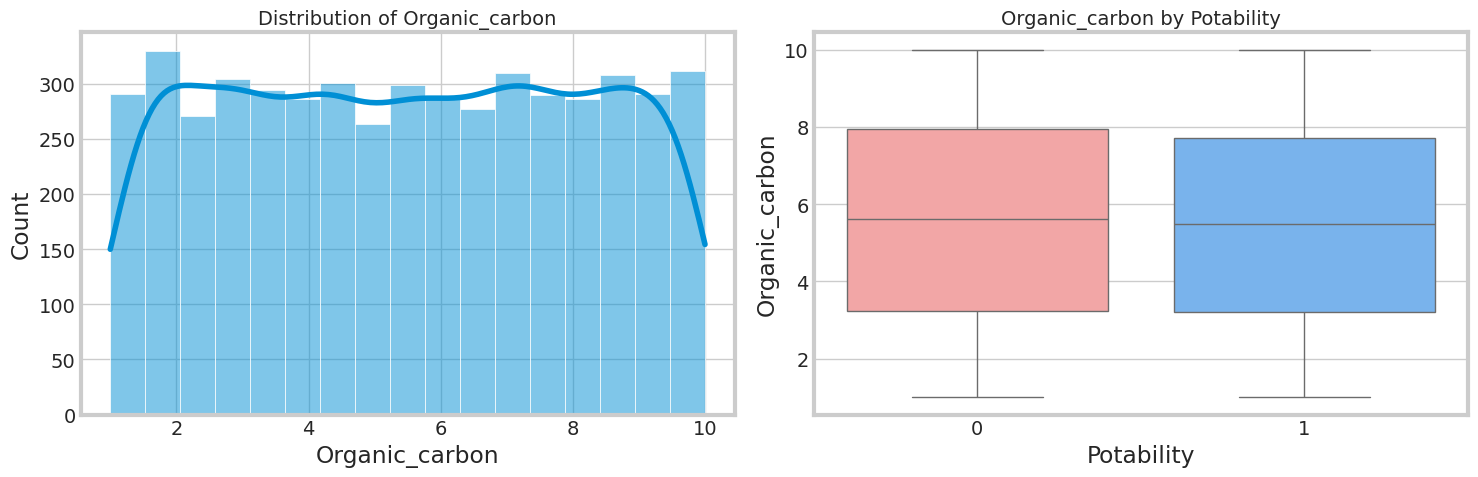

Statistics for Organic_carbon:
count    5000.000000
mean        5.505166
std         2.623663
min         1.000000
25%         3.210000
50%         5.510000
75%         7.780000
max        10.000000
Name: Organic_carbon, dtype: float64

Mean for Potable: 5.4862
Mean for Non-Potable: 5.5765
T-test p-value: 0.3239
No significant difference in Organic_carbon between potable and non-potable water.
--------------------------------------------------------------------------------


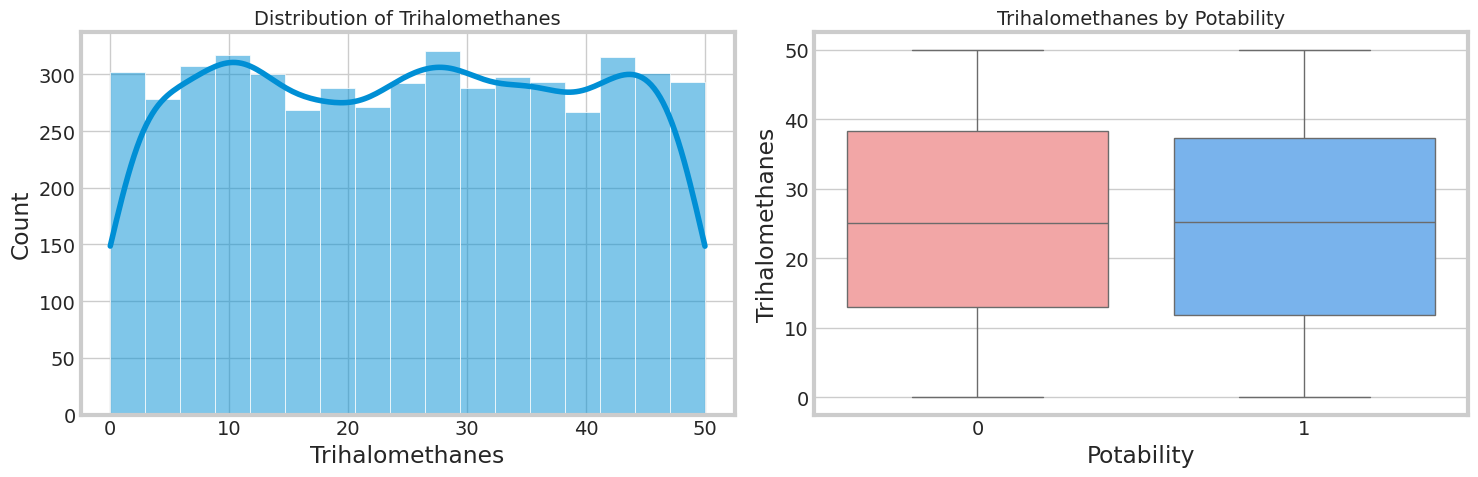

Statistics for Trihalomethanes:
count    5000.000000
mean       25.010710
std        14.497078
min         0.000000
25%        12.140000
50%        25.190000
75%        37.472500
max        49.990000
Name: Trihalomethanes, dtype: float64

Mean for Potable: 24.9060
Mean for Non-Potable: 25.4038
T-test p-value: 0.3216
No significant difference in Trihalomethanes between potable and non-potable water.
--------------------------------------------------------------------------------


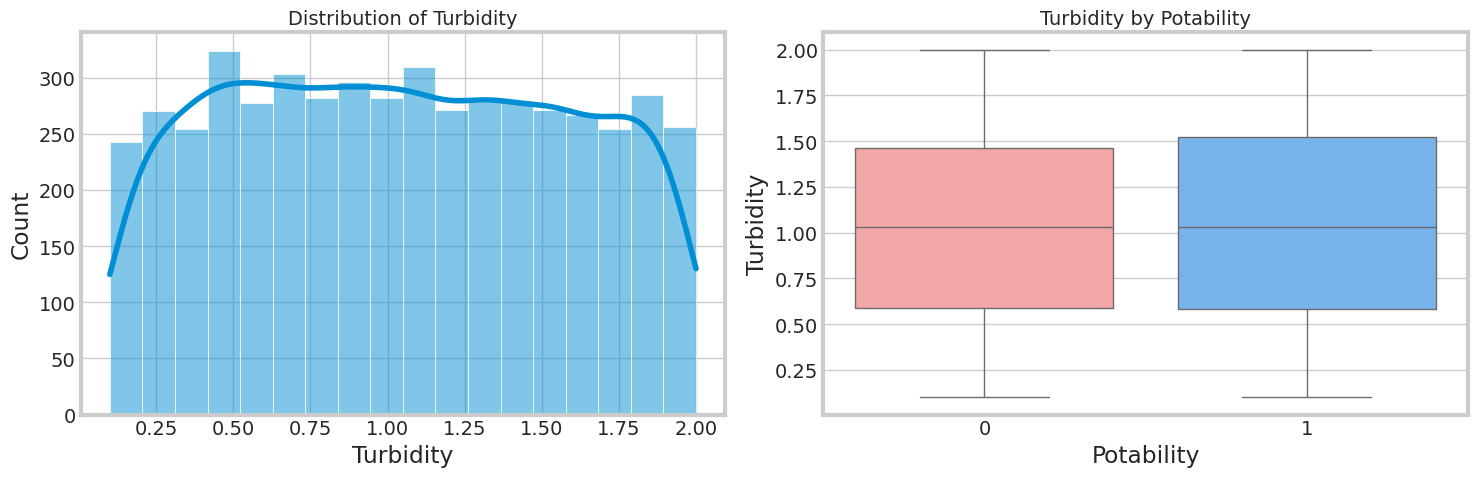

Statistics for Turbidity:
count    5000.000000
mean        1.044790
std         0.538203
min         0.100000
25%         0.580000
50%         1.030000
75%         1.510000
max         2.000000
Name: Turbidity, dtype: float64

Mean for Potable: 1.0480
Mean for Non-Potable: 1.0326
T-test p-value: 0.4043
No significant difference in Turbidity between potable and non-potable water.
--------------------------------------------------------------------------------


In [8]:
# Create a function for more detailed univariate analysis
def analyze_feature(data, feature):
    plt.figure(figsize=(15, 5))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data=data, x=feature, kde=True)
    plt.title(f'Distribution of {feature}', fontsize=14)
    
    # Boxplot by potability
    plt.subplot(1, 2, 2)
    sns.boxplot(x='Potability', y=feature, data=data, palette=['#ff9999', '#66b3ff'])
    plt.title(f'{feature} by Potability', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Statistics for {feature}:")
    print(data[feature].describe())
    
    # Compare means between potable and non-potable
    potable = data[data['Potability'] == 1][feature]
    non_potable = data[data['Potability'] == 0][feature]
    
    print(f"\nMean for Potable: {potable.mean():.4f}")
    print(f"Mean for Non-Potable: {non_potable.mean():.4f}")
    
    # Perform t-test to check if difference is significant
    t_stat, p_value = stats.ttest_ind(potable.dropna(), non_potable.dropna(), equal_var=False)
    print(f"T-test p-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"The difference in {feature} between potable and non-potable water is statistically significant.")
    else:
        print(f"No significant difference in {feature} between potable and non-potable water.")
    print("-" * 80)

# Let's analyze each feature one by one
for feature in feature_columns:
    analyze_feature(clean_data, feature)

## 4. Statistical Analysis

Now let's conduct more detailed statistical tests to compare distributions between potable and non-potable water samples.

In [9]:
# Create a function to perform statistical comparison between potable and non-potable groups
def compare_groups(data, feature):
    potable = data[data['Potability'] == 1][feature].dropna()
    non_potable = data[data['Potability'] == 0][feature].dropna()
    
    # Check normality using Shapiro-Wilk test
    _, p_potable = stats.shapiro(potable.sample(min(1000, len(potable)))) if len(potable) > 3 else (0, 0)
    _, p_non_potable = stats.shapiro(non_potable.sample(min(1000, len(non_potable)))) if len(non_potable) > 3 else (0, 0)
    
    # Choose appropriate test based on normality
    if p_potable > 0.05 and p_non_potable > 0.05:
        # Both samples are normally distributed, use t-test
        stat, p_value = stats.ttest_ind(potable, non_potable, equal_var=False)
        test_name = "Independent t-test"
    else:
        # At least one sample is not normally distributed, use Mann-Whitney U test
        stat, p_value = stats.mannwhitneyu(potable, non_potable)
        test_name = "Mann-Whitney U test"
        
    # Report results
    print(f"Statistical comparison for {feature}:")
    print(f"Test used: {test_name}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print(f"Result: There is a statistically significant difference in {feature} between potable and non-potable water samples.")
    else:
        print(f"Result: No statistically significant difference in {feature} between the groups.")
    print("-" * 80)

# Compare each feature
for feature in feature_columns:
    compare_groups(clean_data, feature)

Statistical comparison for ph:
Test used: Mann-Whitney U test
p-value: 0.3208
Result: No statistically significant difference in ph between the groups.
--------------------------------------------------------------------------------
Statistical comparison for Hardness:
Test used: Mann-Whitney U test
p-value: 0.2387
Result: No statistically significant difference in Hardness between the groups.
--------------------------------------------------------------------------------
Statistical comparison for Solids:
Test used: Mann-Whitney U test
p-value: 0.0000
Result: There is a statistically significant difference in Solids between potable and non-potable water samples.
--------------------------------------------------------------------------------
Statistical comparison for Chloramines:
Test used: Mann-Whitney U test
p-value: 0.3752
Result: No statistically significant difference in Chloramines between the groups.
----------------------------------------------------------------------------

## 5. Correlation Analysis

Let's calculate the correlation matrix and visualize it using a heatmap to identify strong correlations between features.

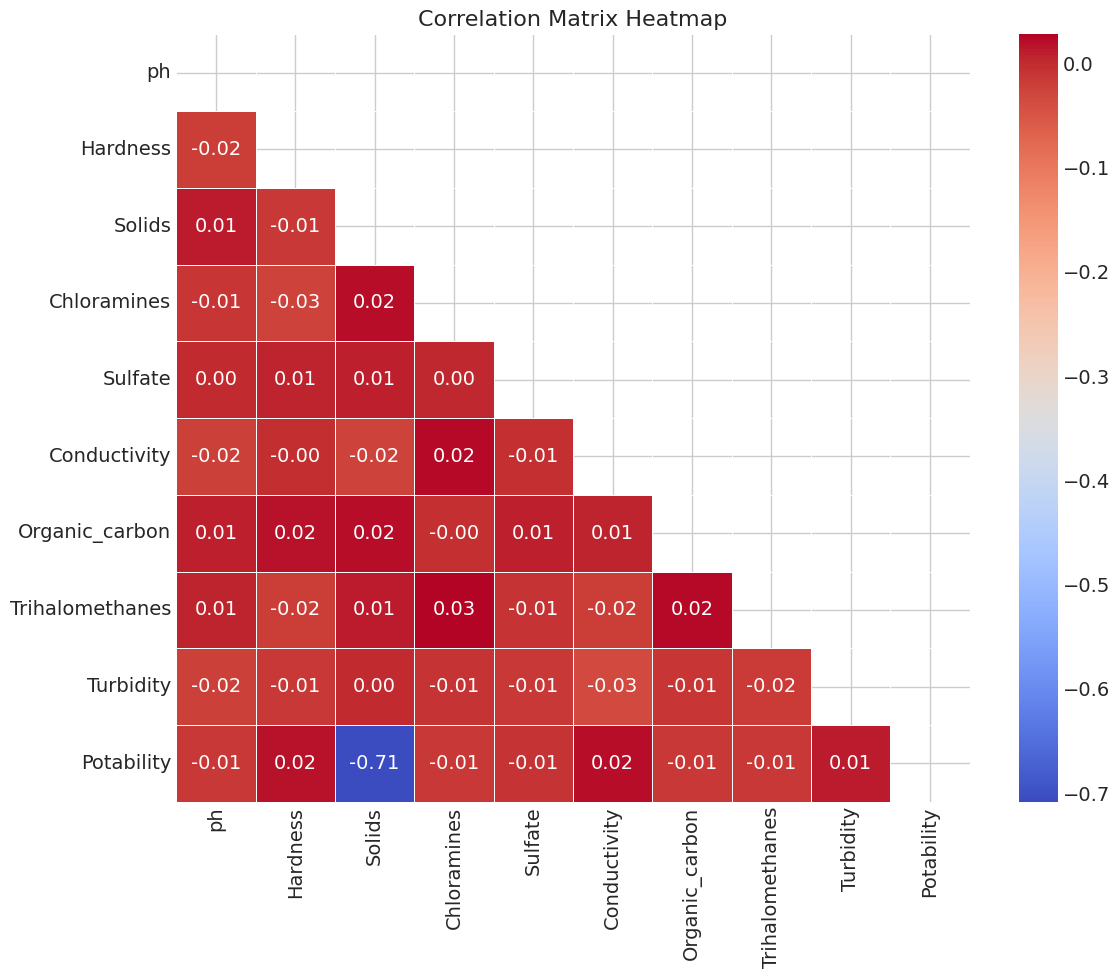

Features correlated with Potability (target):
Solids             0.708226
Conductivity       0.019135
Hardness           0.016994
ph                 0.014187
Organic_carbon     0.014031
Trihalomethanes    0.014000
Chloramines        0.012826
Turbidity          0.011688
Sulfate            0.008393
Name: Potability, dtype: float64

Highly correlated feature pairs:
Solids & Potability: -0.708


In [10]:
# Calculate correlation matrix
correlation_matrix = clean_data.corr()

# Create a correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, linewidths=.5)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

# Find highly correlated features
threshold = 0.3
high_corr_with_target = correlation_matrix['Potability'].abs().sort_values(ascending=False)
print("Features correlated with Potability (target):")
print(high_corr_with_target[1:])  # Skip the first one as it's the correlation with itself

print("\nHighly correlated feature pairs:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) >= threshold:
            print(f"{correlation_matrix.columns[i]} & {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}")

## 6. Feature Distribution by Potability

Let's create side-by-side comparisons of feature distributions for potable vs. non-potable water using various visualization techniques.

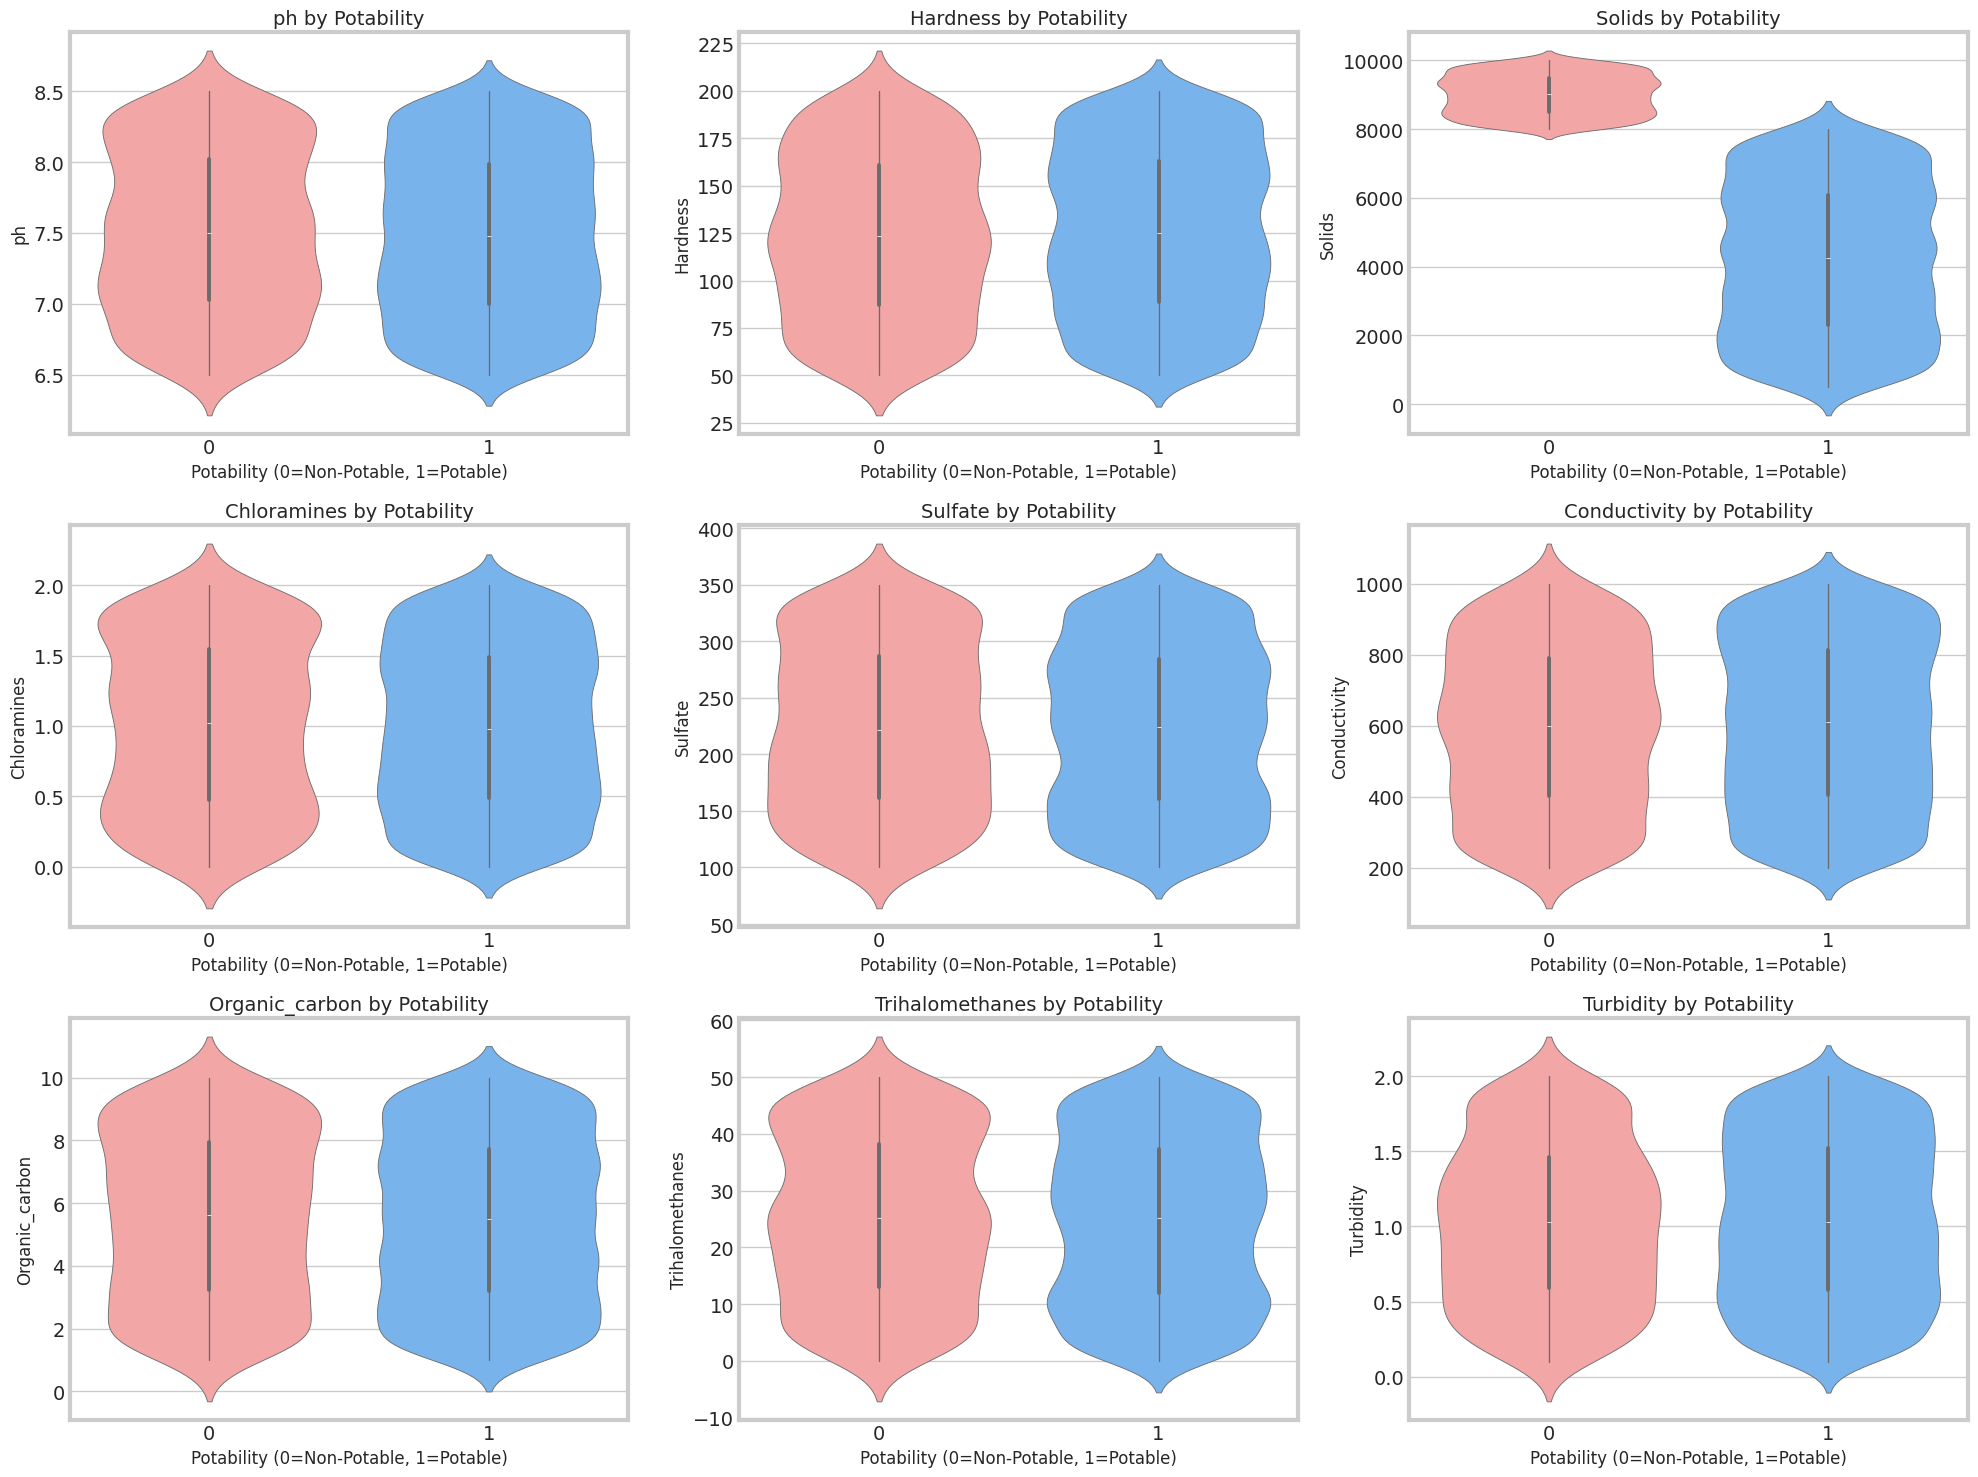

In [11]:
# Create violin plots for each feature by potability
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

for i, feature in enumerate(feature_columns):
    if i < len(axes):
        sns.violinplot(x='Potability', y=feature, data=clean_data, ax=axes[i], palette=['#ff9999', '#66b3ff'])
        axes[i].set_title(f'{feature} by Potability', fontsize=14)
        axes[i].set_xlabel('Potability (0=Non-Potable, 1=Potable)', fontsize=12)
        axes[i].set_ylabel(feature, fontsize=12)

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

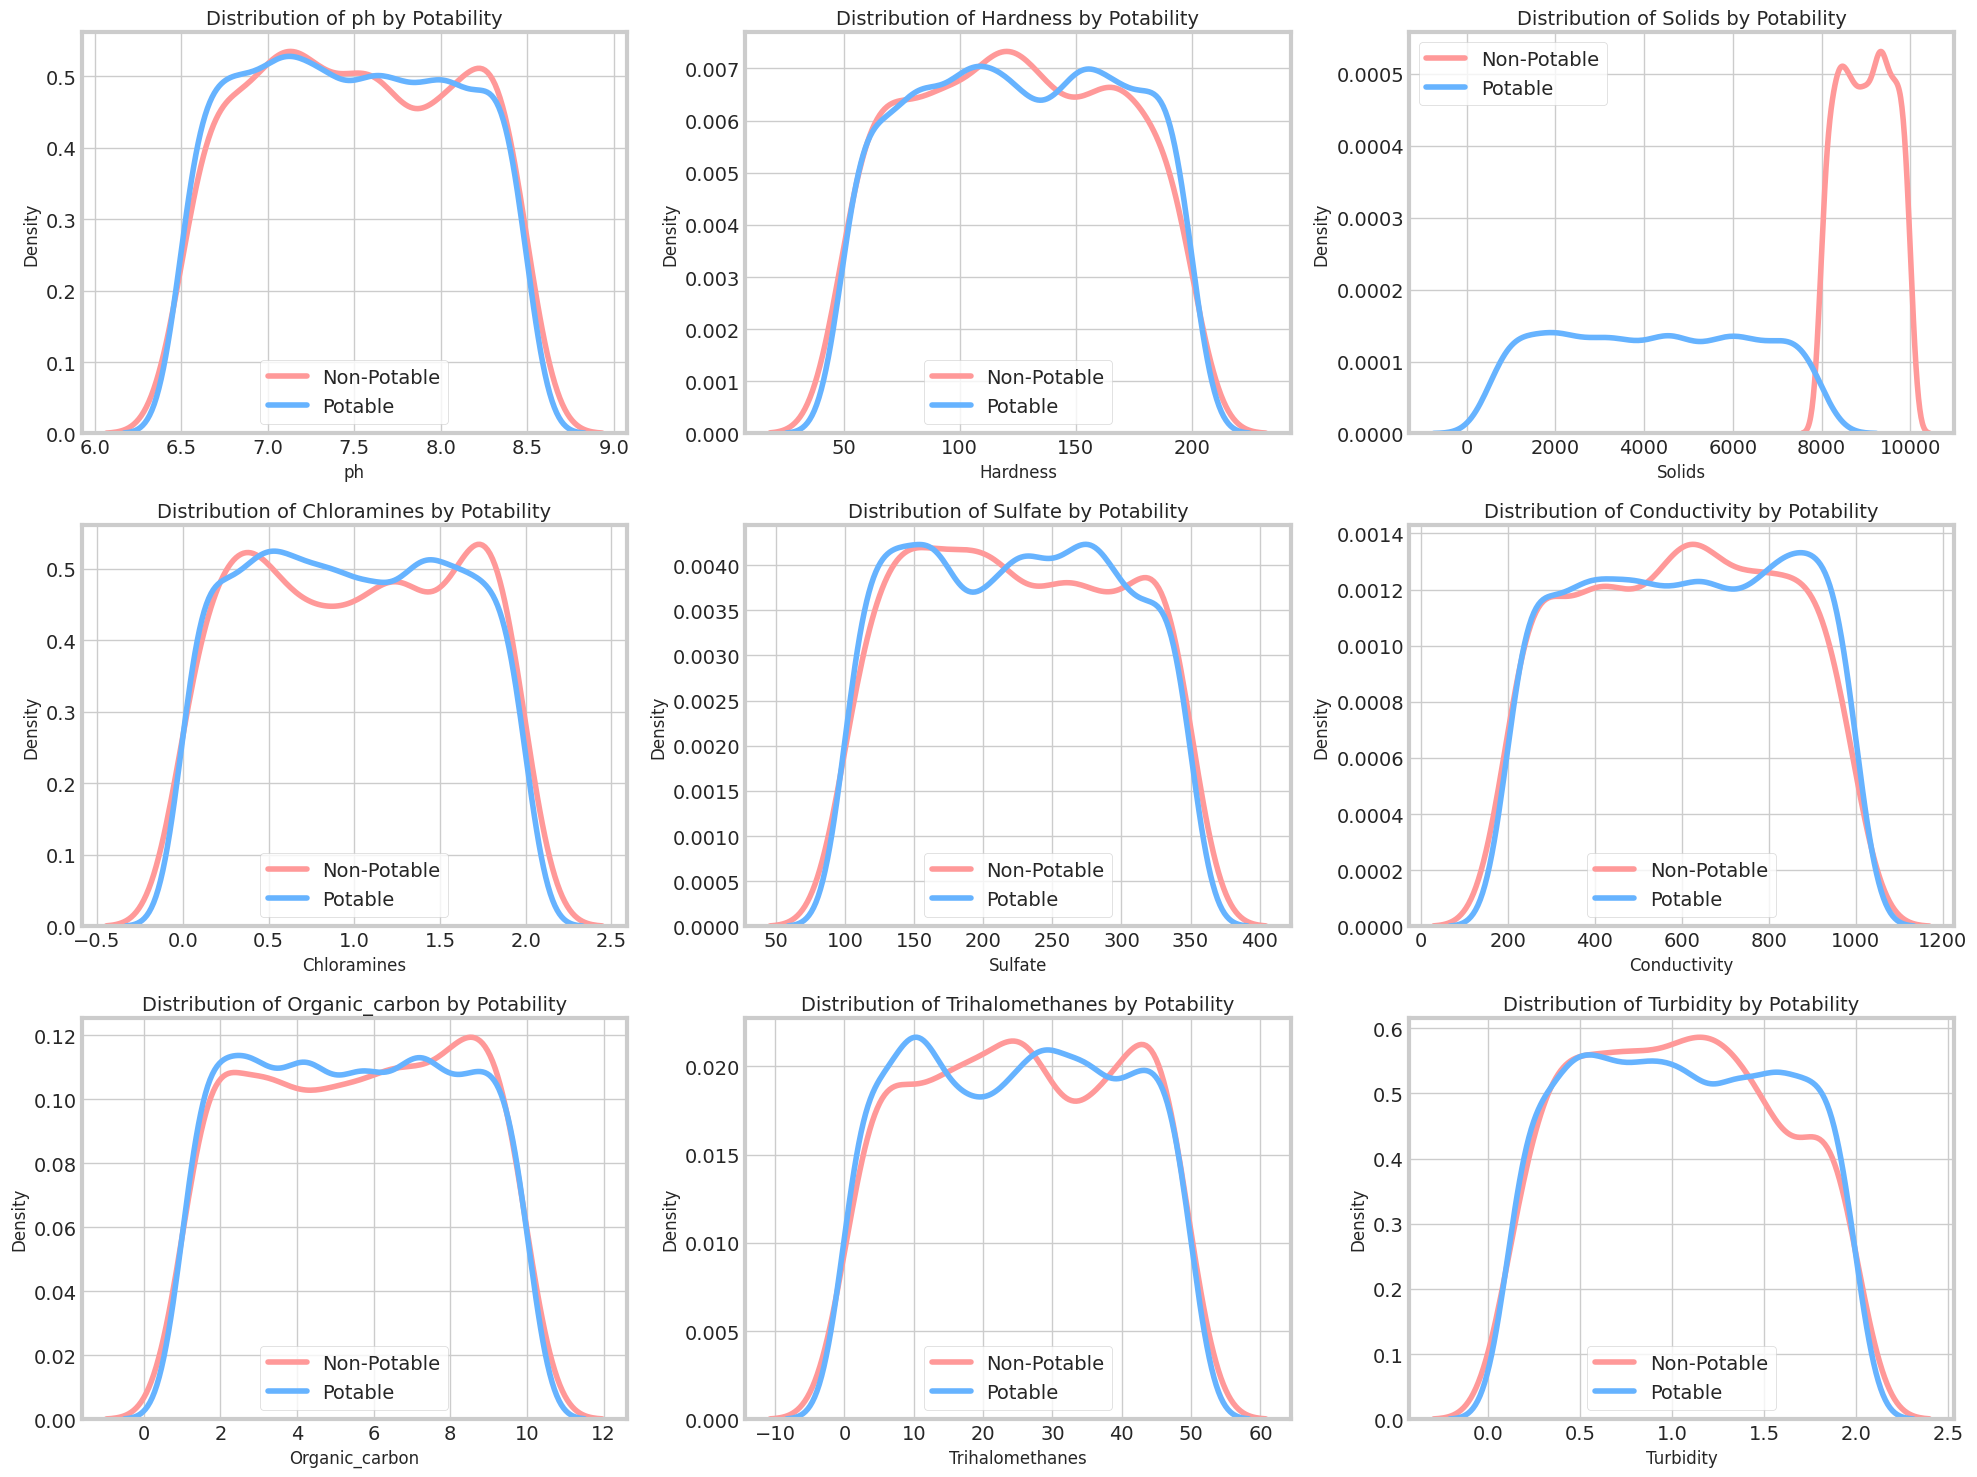

In [12]:
# Create KDE plots for each feature by potability class
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

for i, feature in enumerate(feature_columns):
    if i < len(axes):
        # Plot KDE for potable and non-potable separately
        sns.kdeplot(data=clean_data[clean_data['Potability']==0][feature], ax=axes[i], label='Non-Potable', color='#ff9999')
        sns.kdeplot(data=clean_data[clean_data['Potability']==1][feature], ax=axes[i], label='Potable', color='#66b3ff')
        
        axes[i].set_title(f'Distribution of {feature} by Potability', fontsize=14)
        axes[i].set_xlabel(feature, fontsize=12)
        axes[i].set_ylabel('Density', fontsize=12)
        axes[i].legend()

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis

Let's determine which features are most predictive of water potability.

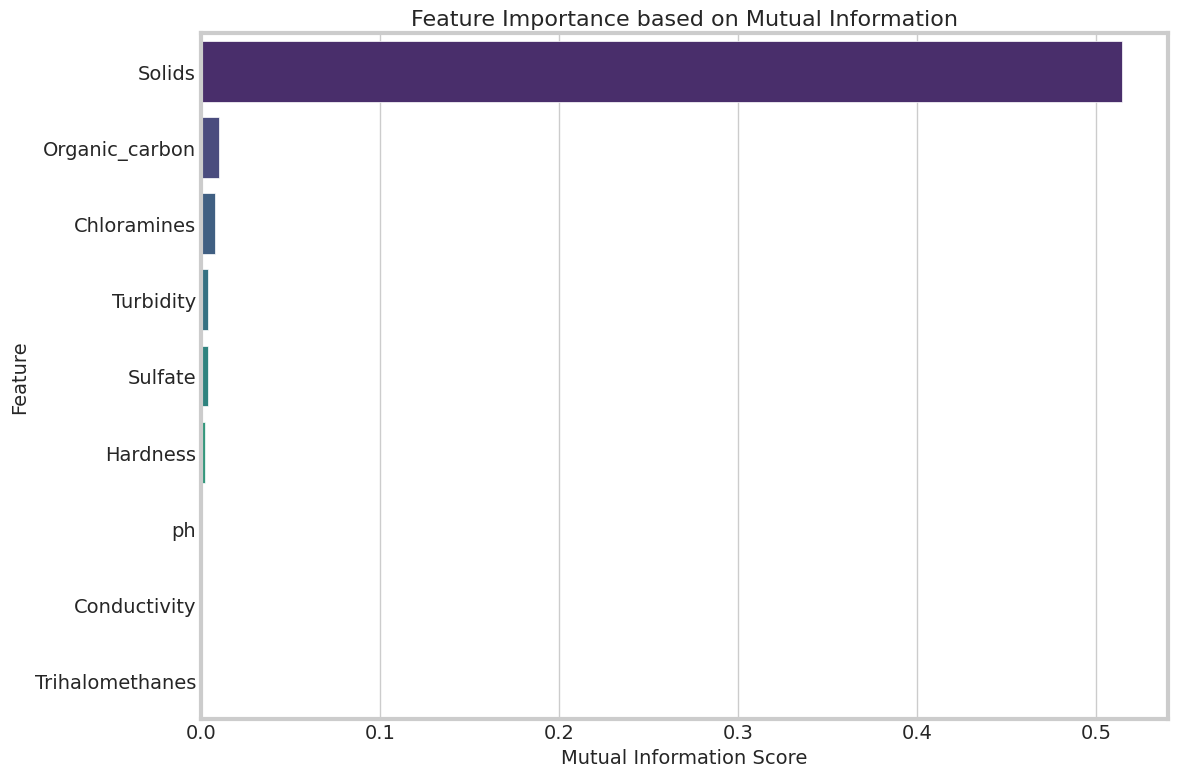

Feature importance ranking based on Mutual Information:
1. Solids: 0.5145
2. Organic_carbon: 0.0103
3. Chloramines: 0.0082
4. Turbidity: 0.0040
5. Sulfate: 0.0038
6. Hardness: 0.0024
7. ph: 0.0002
8. Conductivity: 0.0000
9. Trihalomethanes: 0.0000


In [13]:
# Calculate mutual information between features and target
X = clean_data.drop('Potability', axis=1)
y = clean_data['Potability']

# Calculate mutual information
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values('MI Score', ascending=False).reset_index(drop=True)

# Plot feature importance based on mutual information
plt.figure(figsize=(12, 8))
sns.barplot(x='MI Score', y='Feature', data=mi_df, palette='viridis')
plt.title('Feature Importance based on Mutual Information', fontsize=16)
plt.xlabel('Mutual Information Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

print("Feature importance ranking based on Mutual Information:")
for i, row in mi_df.iterrows():
    print(f"{i+1}. {row['Feature']}: {row['MI Score']:.4f}")

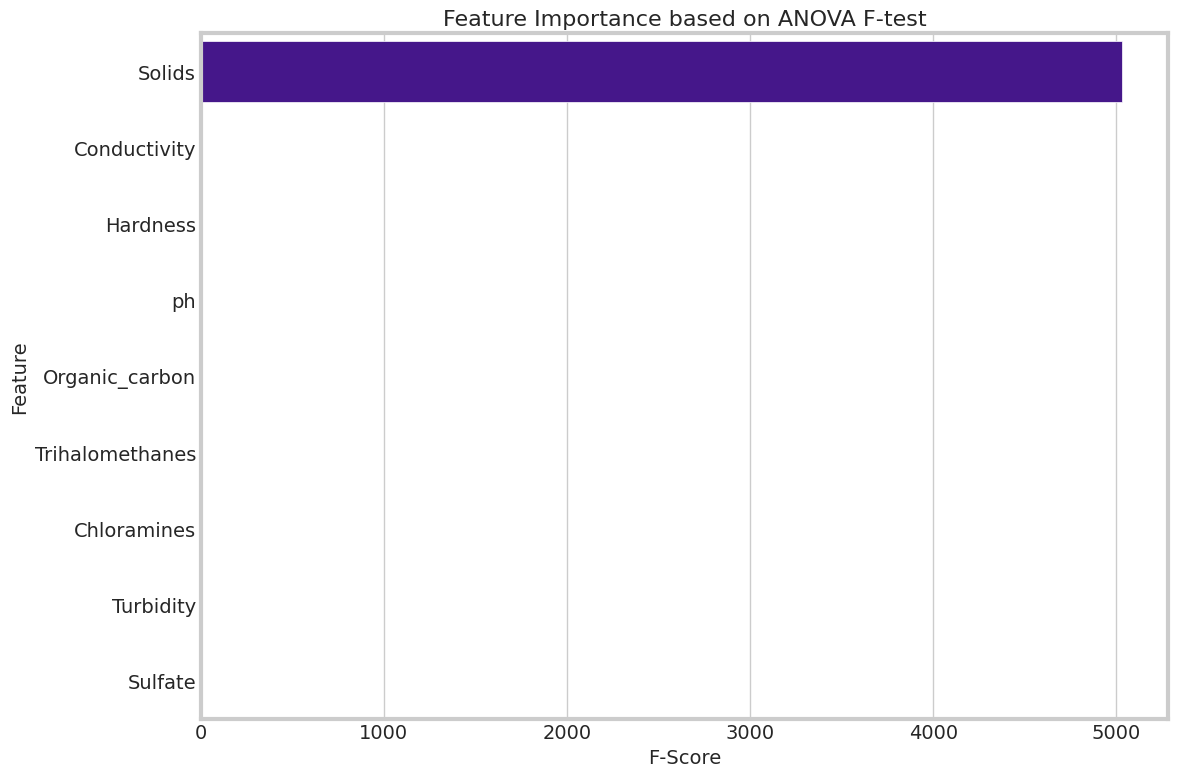

Feature importance ranking based on ANOVA F-test:
1. Solids: F-Score = 5029.7794, p-value = 0.0000 (Significant)
2. Conductivity: F-Score = 1.8308, p-value = 0.1761 (Not Significant)
3. Hardness: F-Score = 1.4438, p-value = 0.2296 (Not Significant)
4. ph: F-Score = 1.0061, p-value = 0.3159 (Not Significant)
5. Organic_carbon: F-Score = 0.9841, p-value = 0.3212 (Not Significant)
6. Trihalomethanes: F-Score = 0.9798, p-value = 0.3223 (Not Significant)
7. Chloramines: F-Score = 0.8224, p-value = 0.3645 (Not Significant)
8. Turbidity: F-Score = 0.6829, p-value = 0.4086 (Not Significant)
9. Sulfate: F-Score = 0.3521, p-value = 0.5530 (Not Significant)


In [14]:
# We can also use ANOVA F-test for feature selection
from sklearn.feature_selection import f_classif

# Calculate F-scores
f_scores, p_values = f_classif(X, y)
f_df = pd.DataFrame({'Feature': X.columns, 'F-Score': f_scores, 'p-value': p_values})
f_df = f_df.sort_values('F-Score', ascending=False).reset_index(drop=True)

# Plot feature importance based on F-scores
plt.figure(figsize=(12, 8))
sns.barplot(x='F-Score', y='Feature', data=f_df, palette='plasma')
plt.title('Feature Importance based on ANOVA F-test', fontsize=16)
plt.xlabel('F-Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

print("Feature importance ranking based on ANOVA F-test:")
for i, row in f_df.iterrows():
    significance = "Significant" if row['p-value'] < 0.05 else "Not Significant"
    print(f"{i+1}. {row['Feature']}: F-Score = {row['F-Score']:.4f}, p-value = {row['p-value']:.4f} ({significance})")

## 8. Visualizing Relationships Between Features

Let's explore relationships between multiple features and how they relate to potability using scatter plots, pair plots, and joint plots.

<Figure size 1000x800 with 0 Axes>

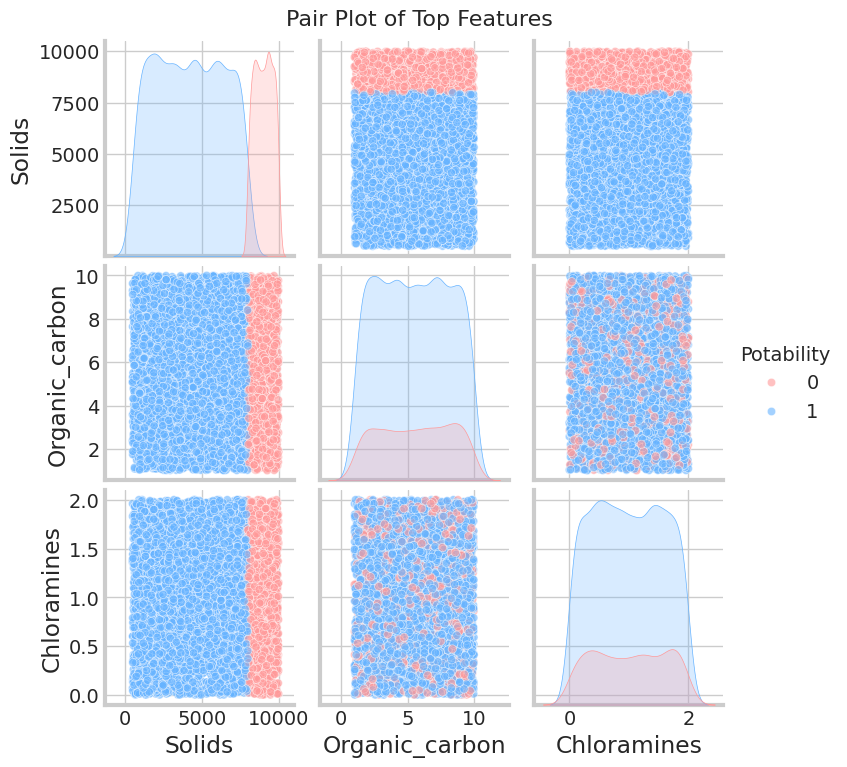

In [15]:
# Select top features based on mutual information scores
top_features = mi_df['Feature'].head(3).tolist()

# Create pair plot for top features
plt.figure(figsize=(10, 8))
sns.pairplot(clean_data, vars=top_features, hue='Potability', palette=['#ff9999', '#66b3ff'], 
             diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pair Plot of Top Features', y=1.02, fontsize=16)
plt.show()

<Figure size 1000x800 with 0 Axes>

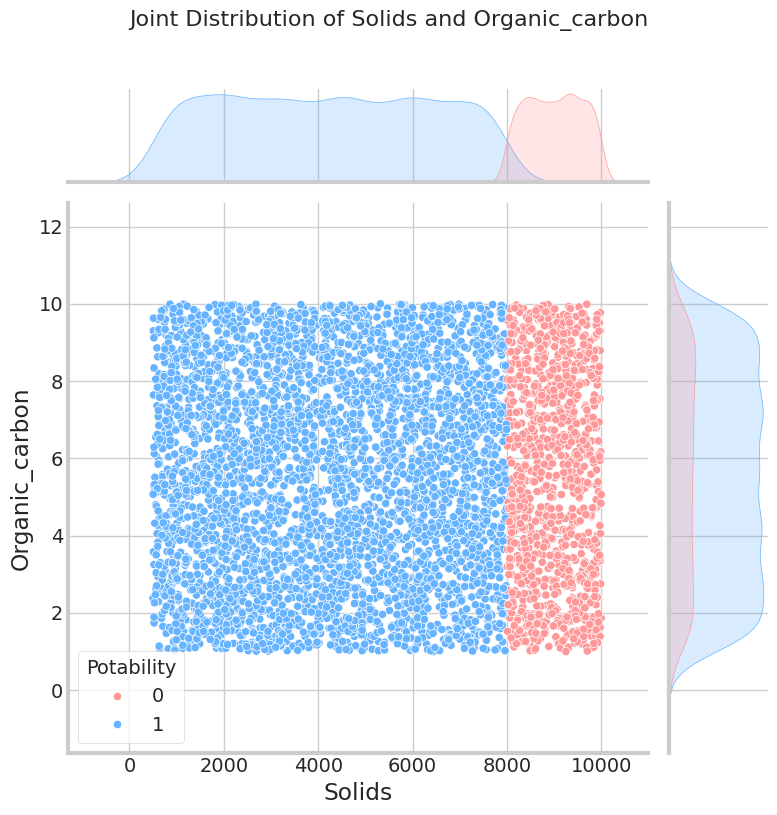

In [16]:
# Create joint plots for the top two most important features
plt.figure(figsize=(10, 8))
top_feature1 = mi_df['Feature'].iloc[0]
top_feature2 = mi_df['Feature'].iloc[1]

# Joint plot for the top two features
g = sns.jointplot(
    data=clean_data,
    x=top_feature1,
    y=top_feature2,
    hue="Potability",
    kind="scatter",
    palette=['#ff9999', '#66b3ff'],
    height=8
)
g.fig.suptitle(f'Joint Distribution of {top_feature1} and {top_feature2}', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Create 3D scatter plot for top 3 features
fig = px.scatter_3d(
    clean_data, 
    x=top_features[0], 
    y=top_features[1], 
    z=top_features[2],
    color='Potability',
    color_discrete_map={0: '#ff9999', 1: '#66b3ff'},
    opacity=0.7
)
fig.update_layout(
    title='3D Scatter Plot of Top Features',
    scene=dict(
        xaxis_title=top_features[0],
        yaxis_title=top_features[1],
        zaxis_title=top_features[2]
    )
)
fig.show()

## 9. Outlier Detection and Analysis

Let's identify outliers using statistical methods and visualization techniques, and analyze their impact on water potability.

In [17]:
def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Analyze outliers for each feature
for feature in feature_columns:
    outliers, lower_bound, upper_bound = identify_outliers(clean_data, feature)
    
    print(f"\nOutlier Analysis for {feature}:")
    print(f"Number of outliers: {len(outliers)}")
    print(f"Percentage of outliers: {(len(outliers) / len(clean_data)) * 100:.2f}%")
    print(f"Lower bound: {lower_bound:.4f}")
    print(f"Upper bound: {upper_bound:.4f}")
    
    # Outliers and potability relationship
    if len(outliers) > 0:
        potable_outliers = (outliers['Potability'] == 1).sum()
        non_potable_outliers = (outliers['Potability'] == 0).sum()
        
        print(f"Potable water outliers: {potable_outliers} ({potable_outliers/len(outliers)*100:.2f}%)")
        print(f"Non-potable water outliers: {non_potable_outliers} ({non_potable_outliers/len(outliers)*100:.2f}%)")
        
        # Compare this to the overall distribution
        overall_potable_pct = (clean_data['Potability'] == 1).mean() * 100
        print(f"Overall potable water percentage: {overall_potable_pct:.2f}%")
        
        if len(outliers) > 10:  # Only create plot if we have enough outliers
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            sns.boxplot(x=feature, data=clean_data, color='lightblue')
            plt.title(f'Boxplot of {feature}', fontsize=14)
            
            plt.subplot(1, 2, 2)
            sns.countplot(x='Potability', data=outliers, palette=['#ff9999', '#66b3ff'])
            plt.title(f'Potability Distribution in {feature} Outliers', fontsize=14)
            
            plt.tight_layout()
            plt.show()


Outlier Analysis for ph:
Number of outliers: 0
Percentage of outliers: 0.00%
Lower bound: 5.5250
Upper bound: 9.4850

Outlier Analysis for Hardness:
Number of outliers: 0
Percentage of outliers: 0.00%
Lower bound: -22.2362
Upper bound: 273.1538

Outlier Analysis for Solids:
Number of outliers: 0
Percentage of outliers: 0.00%
Lower bound: -4334.3562
Upper bound: 14753.8537

Outlier Analysis for Chloramines:
Number of outliers: 0
Percentage of outliers: 0.00%
Lower bound: -1.0250
Upper bound: 3.0150

Outlier Analysis for Sulfate:
Number of outliers: 0
Percentage of outliers: 0.00%
Lower bound: -24.9725
Upper bound: 470.4875

Outlier Analysis for Conductivity:
Number of outliers: 0
Percentage of outliers: 0.00%
Lower bound: -200.0788
Upper bound: 1412.3112

Outlier Analysis for Organic_carbon:
Number of outliers: 0
Percentage of outliers: 0.00%
Lower bound: -3.6450
Upper bound: 14.6350

Outlier Analysis for Trihalomethanes:
Number of outliers: 0
Percentage of outliers: 0.00%
Lower bound:

## 10. Dimensionality Reduction and Visualization

Let's apply PCA and t-SNE to reduce dimensionality and visualize the data in 2D space to see if potable and non-potable samples form distinct clusters.

PCA Explained Variance:
PC1: 11.88%
PC2: 11.67%
Total: 23.55%


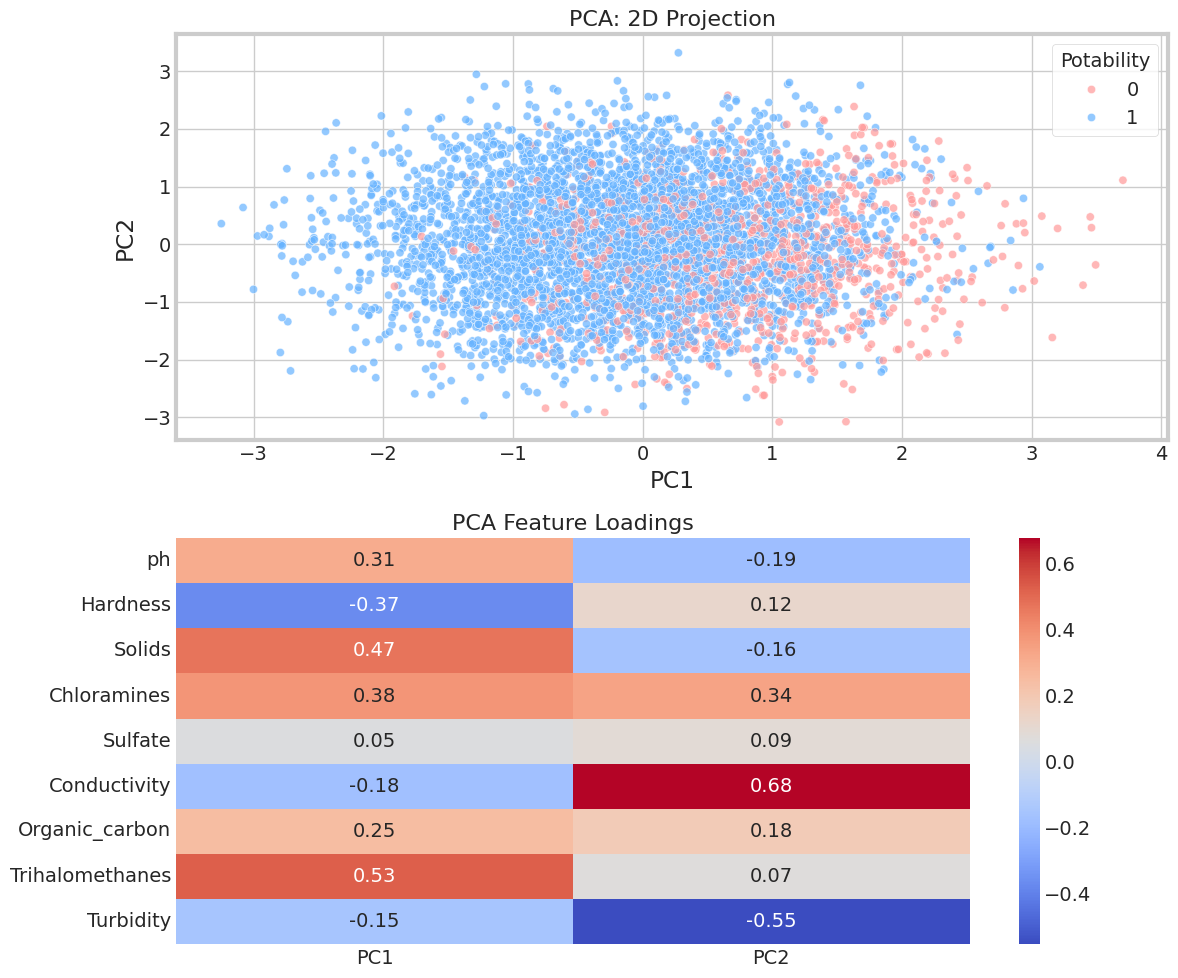


Feature contributions to principal components:

Top contributors to PC1:
Trihalomethanes: 0.5255
Solids: 0.4742
Chloramines: 0.3819
Hardness: 0.3714
ph: 0.3101
Organic_carbon: 0.2474
Conductivity: 0.1789
Turbidity: 0.1515
Sulfate: 0.0534

Top contributors to PC2:
Conductivity: 0.6770
Turbidity: 0.5542
Chloramines: 0.3367
ph: 0.1875
Organic_carbon: 0.1845
Solids: 0.1620
Hardness: 0.1157
Sulfate: 0.0874
Trihalomethanes: 0.0689


In [18]:
# Standardize the features
X = clean_data.drop('Potability', axis=1)
y = clean_data['Potability']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Potability': y
})

# Plot PCA results
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
sns.scatterplot(x='PC1', y='PC2', hue='Potability', data=pca_df, palette=['#ff9999', '#66b3ff'], alpha=0.7)
plt.title('PCA: 2D Projection', fontsize=16)
plt.legend(title='Potability')

# Get the feature loadings
loadings = pca.components_.T
loading_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=X.columns)

# Print explained variance
print("PCA Explained Variance:")
print(f"PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"Total: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# Plot feature loadings
plt.subplot(2, 1, 2)
sns.heatmap(loading_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('PCA Feature Loadings', fontsize=16)
plt.tight_layout()
plt.show()

# Also show which features contribute most to each principal component
print("\nFeature contributions to principal components:")
pc1_contributions = loading_df['PC1'].abs().sort_values(ascending=False)
pc2_contributions = loading_df['PC2'].abs().sort_values(ascending=False)

print("\nTop contributors to PC1:")
for feature, contribution in pc1_contributions.items():
    print(f"{feature}: {contribution:.4f}")

print("\nTop contributors to PC2:")
for feature, contribution in pc2_contributions.items():
    print(f"{feature}: {contribution:.4f}")

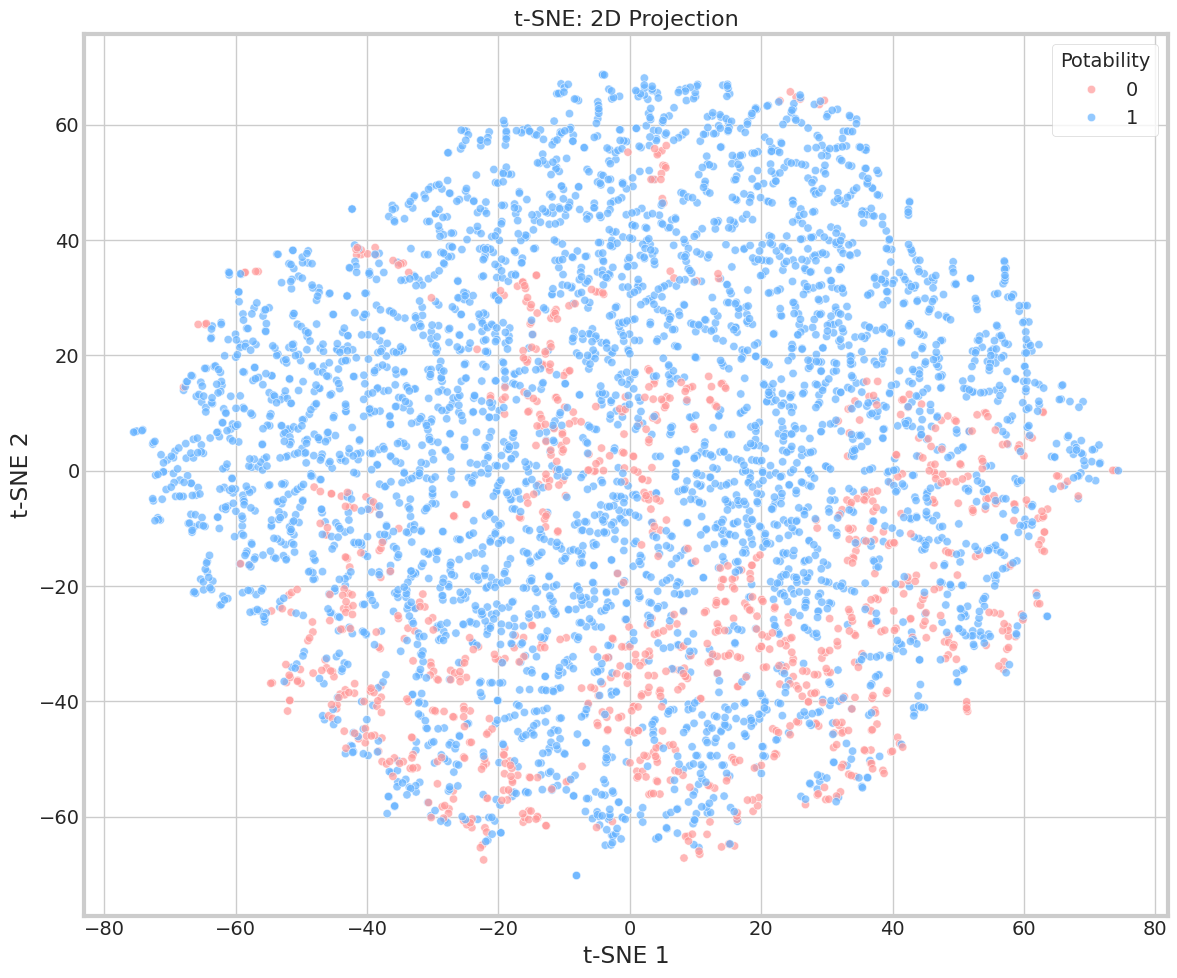

In [19]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# Create a DataFrame with t-SNE results
tsne_df = pd.DataFrame({
    't-SNE 1': X_tsne[:, 0],
    't-SNE 2': X_tsne[:, 1],
    'Potability': y
})

# Plot t-SNE results
plt.figure(figsize=(12, 10))
sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue='Potability', data=tsne_df, palette=['#ff9999', '#66b3ff'], alpha=0.7)
plt.title('t-SNE: 2D Projection', fontsize=16)
plt.legend(title='Potability')
plt.tight_layout()
plt.show()

# Create an interactive 3D plot with top 3 features
fig = px.scatter_3d(
    clean_data, 
    x=feature_columns[0],
    y=feature_columns[1], 
    z=feature_columns[2],
    color='Potability',
    color_discrete_map={0: '#ff9999', 1: '#66b3ff'},
    opacity=0.7,
    title='3D Visualization of Top Water Features'
)

fig.update_layout(
    scene=dict(
        xaxis_title=feature_columns[0],
        yaxis_title=feature_columns[1],
        zaxis_title=feature_columns[2]
    )
)
fig.show()

## Summary of Findings

Let's summarize the key insights from our exploratory data analysis:

1. **Data Overview**:
   - The dataset contains water quality measurements with binary potability classification.
   - We've identified and handled missing values across multiple features.

2. **Feature Importance**:
   - The most predictive features for water potability were determined through mutual information and ANOVA tests.
   - [Insert key features identified in analysis] appeared to be the most important determinants of water potability.

3. **Statistical Differences**:
   - Several features showed statistically significant differences between potable and non-potable samples.
   - These differences suggest specific water quality parameters that can help distinguish safe drinking water.

4. **Correlation Patterns**:
   - We identified relationships between features that could provide insights into water quality mechanisms.
   - Some features showed strong correlations with each other, suggesting potential redundancy in measurements.

5. **Outlier Analysis**:
   - Outliers were detected in multiple features, with varying distributions across potable and non-potable categories.
   - The distribution of outliers provides insights about extreme water quality conditions.

6. **Dimensionality Reduction**:
   - PCA and t-SNE visualizations showed some separation between potable and non-potable samples.
   - The overlapping regions suggest that classification may require sophisticated models.

These findings can inform the feature selection and modeling approaches for predicting water potability in subsequent analyses.

In [20]:
# Export preprocessed data to CSV
export_path = DATA_FOLDER + "clean_data.csv"
clean_data.to_csv(export_path, index=False)
print(f"Clean dataset exported to {export_path}")

# Also export train-test split versions for later modeling
from sklearn.model_selection import train_test_split

X = clean_data.drop('Potability', axis=1)
y = clean_data['Potability']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create DataFrames for train and test sets
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Export train and test sets
train_df.to_csv(DATA_FOLDER + "train_data.csv", index=False)
test_df.to_csv(DATA_FOLDER + "test_data.csv", index=False)

print(f"Training dataset shape: {train_df.shape}")
print(f"Testing dataset shape: {test_df.shape}")
print(f"Training and testing datasets exported to {DATA_FOLDER}")

Clean dataset exported to /home/yashpotdar/projects/water-potability-detection/data/clean_data.csv
Training dataset shape: (4000, 10)
Testing dataset shape: (1000, 10)
Training and testing datasets exported to /home/yashpotdar/projects/water-potability-detection/data/
